In [1]:
import numpy as np
import pandas as pd
from os import path
import pickle
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]

n_bins_default = 15

In [2]:
def load_cache(file_path):
    with open(path.expanduser(file_path), 'rb') as f:
        cache_dict = pickle.load(f)
        df = cache_dict['df']
        p = list(cache_dict['parameter_names'])
        return df, p

In [3]:
class ModelPlot:
    def __init__(self, label, color, d, linewidth=3):
        self.label = label
        self.color = color
        self.linewidth = linewidth
        self.d=d

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

def plot_model(model_plot_list, n_bins, ax=None, percentiles=False):
    p = ax if ax is not None else plt
    for model_plot in model_plot_list:
        d_grouped_by_gs = model_plot.d.groupby(pd.cut(model_plot.d.tev, n_bins))
        d_grouped_by_gs_agg = d_grouped_by_gs.agg([np.mean, percentile(10), percentile(90)])
        
        p.plot(
            d_grouped_by_gs_agg.tev['mean'],
            d_grouped_by_gs_agg.translation_error['mean'],
            label=model_plot.label,
            color=model_plot.color,
            linewidth=model_plot.linewidth,
        )
        if percentiles:
            p.errorbar(
                d_grouped_by_gs_agg.tev['mean'],
                d_grouped_by_gs_agg.translation_error['mean'],
                yerr=[
                    d_grouped_by_gs_agg.translation_error['percentile_10'],
                    d_grouped_by_gs_agg.translation_error['percentile_90'],
                ], 
                color=model_plot.color,
            )

In [4]:
rename_dict = {
    'relative_localization_error_translation_mean': 'translation_error',
    'geometric_similarity_range_limit_mean_of_translation_eigenvalues_ratio': 'tev',
    'geometric_similarity_mean_of_translation_eigenvalues_ratio': 'tev30',
    'geometric_similarity_range_limit_start_time': 'start_time'
}
p = [
    'laser_scan_max_range',
    'laser_scan_fov_deg',
    'environment_name',
    'slam_node',
]
m = [
    'start_time',
    'translation_error',
    'tev',
    'tev30',
]
df, params = load_cache("/home/enrico/ds/performance_modelling/output/slam_new_config/run_data_per_waypoint_cache.pkl")
df.rename(columns=rename_dict, inplace=True)
df = df[df.beta == (2.0, 0.0, 2.0, 0.0)][p+m]
df.tev = 1 - df.tev

df.loc[df.laser_scan_max_range == 30.0, 'tev'] = df[df.laser_scan_max_range == 30.0].tev30.copy()

for c in p:
    print("{:>30}".format(c), sorted(list(df[c].unique())))


          laser_scan_max_range [3.5, 8.0, 30.0]
            laser_scan_fov_deg [90, 180, 359]
              environment_name ['7A-2', 'airlab', 'fr079', 'office_b']
                     slam_node ['gmapping', 'slam_toolbox']


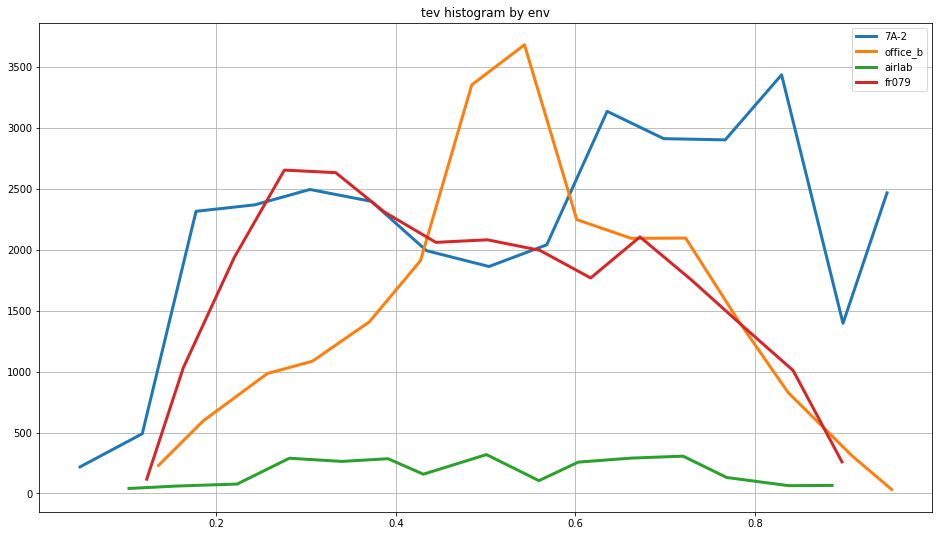

In [5]:
for env_name in df.environment_name.unique():
    df_by_env = df[df.environment_name == env_name]
    df_by_env_bined = df_by_env.groupby(pd.cut(df_by_env.tev, n_bins_default))
    df_hist = df_by_env_bined.agg(['mean', 'count'])
    plt.plot(df_hist[('tev', 'mean')], df_hist[('tev', 'count')], label=env_name, linewidth=3)

plt.title("tev histogram by env")
plt.legend()
plt.grid(True)
plt.show()

min      0.000001
mean     0.531641
max     74.233677
Name: translation_error, dtype: float64


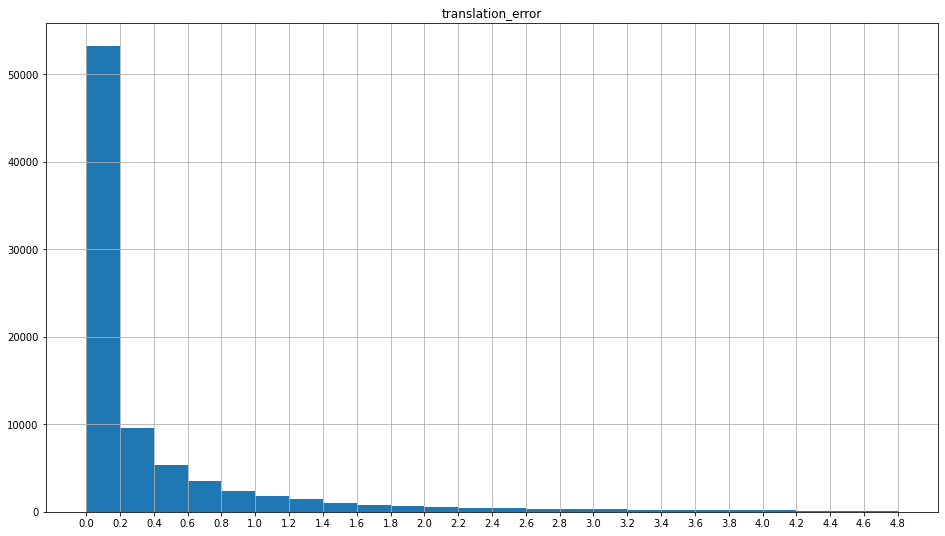

In [6]:
print(df.translation_error.agg(["min", "mean", "max"]))
plt.hist(df.translation_error, bins=np.arange(0, 5, 0.2))
plt.title("translation_error")
plt.xticks(np.arange(0, 5, 0.2))
plt.grid(True)
plt.show()

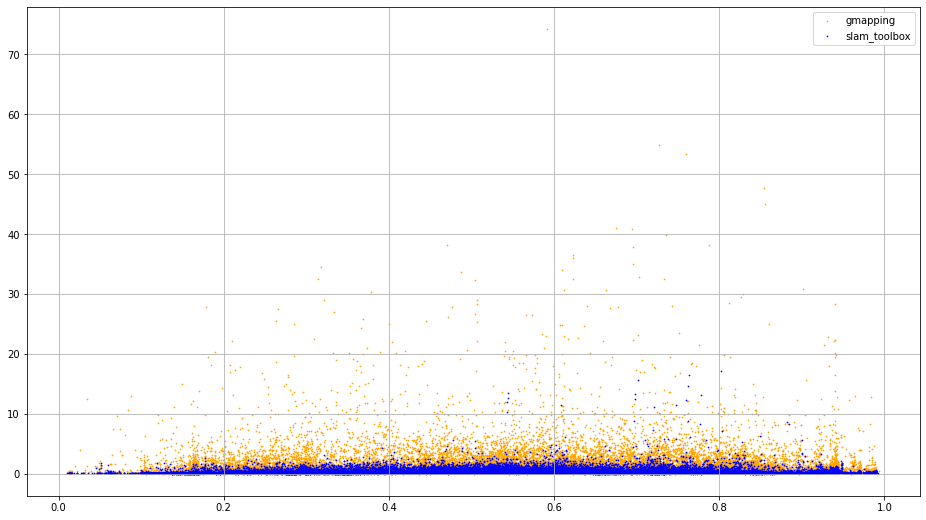

In [7]:
plt.scatter(df[df.slam_node == 'gmapping'].tev, df[df.slam_node == 'gmapping'].translation_error, s=0.5, label='gmapping', color='orange')
plt.scatter(df[df.slam_node == 'slam_toolbox'].tev, df[df.slam_node == 'slam_toolbox'].translation_error, s=0.5, label='slam_toolbox', color='blue')
plt.legend()
plt.grid(True)
plt.show()

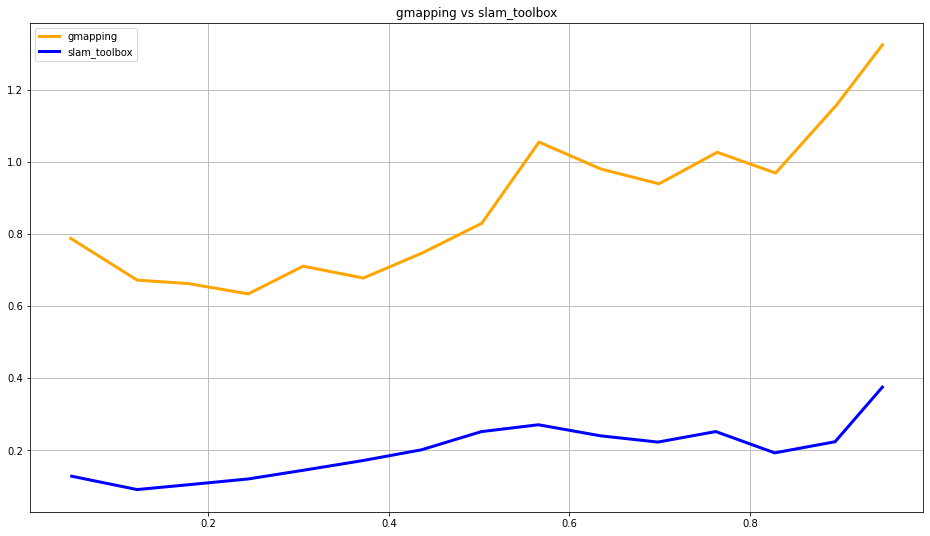

In [8]:
plot_model([
    ModelPlot('gmapping', 'orange', df[df.slam_node == 'gmapping']), 
    ModelPlot('slam_toolbox', 'blue',  df[df.slam_node == 'slam_toolbox'])], 
    n_bins_default)
plt.title("gmapping vs slam_toolbox")
plt.legend()
plt.grid(True)
plt.show()

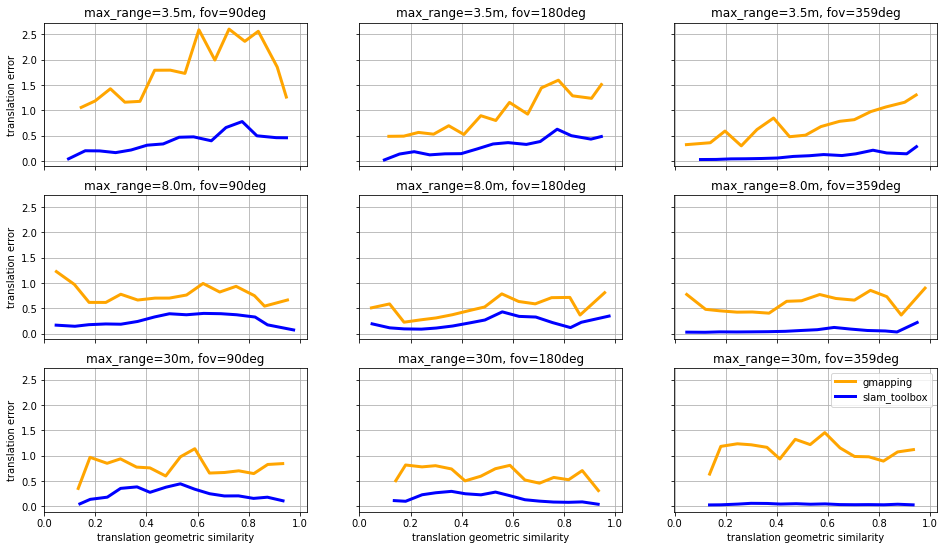

In [9]:

fig, axs = plt.subplots(3, 3)
for ax in axs.flat:
    ax.set(xlabel='translation geometric similarity', ylabel='translation error')
for ax in axs.flat:
    ax.label_outer()

mrs = [3.5, 8.0, 30]
fovs = [90, 180, 359]
for i, mr in enumerate(mrs):
    for j, fov in enumerate(fovs):
        plot_model([
            ModelPlot('gmapping', 'orange', 
                      df[(df.slam_node == 'gmapping') &
                         (df.laser_scan_max_range == mr) &
                         (df.laser_scan_fov_deg == fov)]), 
            ModelPlot('slam_toolbox', 'blue', 
                      df[(df.slam_node == 'slam_toolbox') & 
                      (df.laser_scan_max_range == mr) & 
                      (df.laser_scan_fov_deg == fov)])], 
            n_bins_default,
            axs[i, j])
        axs[i, j].set_title(f"max_range={mr}m, fov={fov}deg")
        axs[i, j].sharex(axs[0, 0])
        axs[i, j].sharey(axs[0, 0])
        axs[i, j].grid(True)
plt.legend()
plt.show()

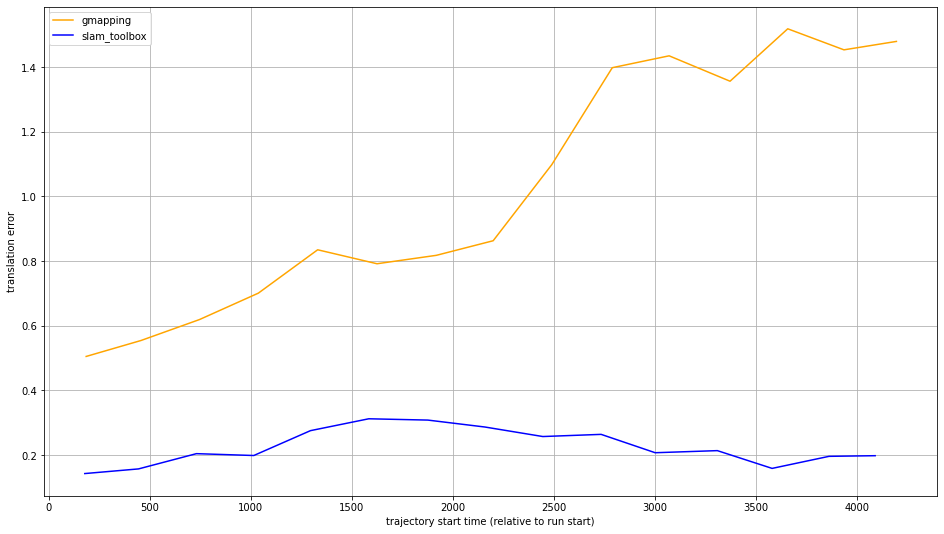

In [15]:
n_bins = 15

df_gm = df[df.slam_node == "gmapping"]
df_gm_grouped_by_start_time = df_gm.groupby(pd.cut(df_gm.start_time, n_bins))
df_gm_grouped_by_start_time_mean = df_gm_grouped_by_start_time.mean()
plt.plot(
    df_gm_grouped_by_start_time_mean.start_time,
    df_gm_grouped_by_start_time_mean.translation_error,
    label="gmapping", color='orange',
)

df_st = df[df.slam_node == "slam_toolbox"]
df_st_grouped_by_start_time = df_st.groupby(pd.cut(df_st.start_time, n_bins))
df_st_grouped_by_start_time_mean = df_st_grouped_by_start_time.mean()
plt.plot(
    df_st_grouped_by_start_time_mean.start_time,
    df_st_grouped_by_start_time_mean.translation_error,
    label="slam_toolbox", color='blue',
)

plt.legend()
plt.xlabel("trajectory start time (relative to run start)")
plt.ylabel("translation error")
plt.grid(True)
plt.show()